In [ ]:
library(Rsubread)
library(dplyr)
library(RColorBrewer)
library(ggplot2)
library(ggrepel)
require(dplyr)
library(reshape2)
library("DESeq2")
library(RColorBrewer)
require('biomaRt')
require('pheatmap')
require('edgeR')

In [2]:
listEnsembl()
mart <- useMart(biomart = "ensembl", 
                dataset = "dmelanogaster_gene_ensembl", 
                host = "https://www.ensembl.org")
mart <- useDataset(dataset="dmelanogaster_gene_ensembl", mart=mart)

biomart,version
<chr>,<chr>
genes,Ensembl Genes 110
mouse_strains,Mouse strains 110
snps,Ensembl Variation 110
regulation,Ensembl Regulation 110


# FeatureCounts

In [21]:
# counts.matrix <-featureCounts(
#               files = c('replicate1_Aligned.sortedByCoord.out.bam',
#                        'replicate2_Aligned.sortedByCoord.out.bam'), 
#               GTF.attrType = "gene_id",
#               annot.ext = "../../genome/Drosophila_melanogaster.BDGP6.32.107.gtf",
#               genome="../../genome/Drosophila_melanogaster.BDGP6.32.dna_sm.toplevel.fa",
#               isGTFAnnotationFile = TRUE,
#               useMetaFeatures=TRUE,
#               GTF.featureType= "three_prime_utr", #we are only interested in reads falling into the 3'UTR
#               nthreads = 40,
#               isPairedEnd = FALSE,
#               requireBothEndsMapped = FALSE,
#               countChimericFragments = FALSE,
#               juncCounts = FALSE,
#               allowMultiOverlap=FALSE
#               )

#using previously saved matrix : 
count.matrix.g080=readRDS("/workspace/hlaghrissi/Analysis/iClipSeq-nov-2019/G080/2.star/iCLIP_UTR3_egfp1_egfp2.rds")
count.matrix.dpld=readRDS('/workspace/hlaghrissi/Analysis/iClipSeq-nov-2019/dPLD/2.star/iCLIP_UTR3_dPLD_egfp1_egfp2.rds')

## G080

In [46]:
count.g080=as.data.frame(count.matrix.g080$counts)
names(count.g080)=c('replicate1_utr3','replicate2_utr3')
print('here the header of the data')
head(count.g080)

[1] "here the header of the data"


,replicate1_utr3,replicate2_utr3
,<int>,<int>
FBgn0250732,160,295
FBgn0037409,0,4
FBgn0027948,273,349
FBgn0038675,5,2
FBgn0000500,4,3
FBgn0037610,3,29


In [47]:
print("original dimension")
dim(count.g080)

#here we remove all the Fbti
keep=NULL
keep <- count.g080[!grepl("FBti", row.names(count.g080)),] 
genesTokeep=which(rownames(count.g080) %in% row.names(keep))
count.g080 <- count.g080[genesTokeep, ]
print("after removing genes with FBti")
dim(count.g080)

#here we remove all the transposable element (they start with RR)
keep=NULL
keep <- count.g080[!grepl("RR", row.names(count.g080)),] 
genesTokeep=which(rownames(count.g080) %in% row.names(keep))
count.g080 <- count.g080[genesTokeep, ]
print("after removing genes with RR")
dim(count.g080)

#here we remove genes with 0 reads in all samples
keep_genes <- rowSums(count.g080) > 0 #TRUE if the gene has more that 0 reads, if not : FALSE
count.g080 <- count.g080[ keep_genes, ]
print("after removing genes with 0 reads")
dim(count.g080) 

#cpm filtering
keep <- rowSums(cpm(count.g080) > 0.5) >=2
count.g080<- count.g080[keep , ]
print('after removing genes with cpm')
dim(count.g080)

[1] "original dimension"


[1] 13526     2

[1] "after removing genes with FBti"


[1] 13526     2

[1] "after removing genes with RR"


[1] 13526     2

[1] "after removing genes with 0 reads"


[1] 10049     2

[1] "after removing genes with cpm"


[1] 6641    2

Calculating the mean of read counts between replicates

In [48]:
count.g080$iclip_UTR3_g080_mean_reads=rowMeans(count.g080)

In [49]:
dim(count.g080)
head(count.g080)

[1] 6641    3

,replicate1_utr3,replicate2_utr3,iclip_UTR3_g080_mean_reads
,<int>,<int>,<dbl>
FBgn0250732,160,295,227.5
FBgn0027948,273,349,311.0
FBgn0038675,5,2,3.5
FBgn0000500,4,3,3.5
FBgn0037610,3,29,16.0
FBgn0261859,393,898,645.5


## DPLD

In [50]:
count.dpld=as.data.frame(count.matrix.dpld$counts)
names(count.dpld)=c('dpld_replicate1_utr3','dpld_replicate2_utr3')
print('here the header of the data')
head(count.dpld)

[1] "here the header of the data"


,dpld_replicate1_utr3,dpld_replicate2_utr3
,<int>,<int>
FBgn0250732,200,267
FBgn0037409,4,1
FBgn0027948,562,644
FBgn0038675,11,0
FBgn0000500,55,32
FBgn0037610,0,6


In [51]:
print("original dimension")
dim(count.dpld)

#here we remove all the Fbti
keep=NULL
keep <- count.dpld[!grepl("FBti", row.names(count.dpld)),] 
genesTokeep=which(rownames(count.dpld) %in% row.names(keep))
count.dpld <- count.dpld[genesTokeep, ]
print("after removing genes with FBti")
dim(count.dpld)

#here we remove all the transposable element (they start with RR)
keep=NULL
keep <- count.dpld[!grepl("RR", row.names(count.dpld)),] 
genesTokeep=which(rownames(count.dpld) %in% row.names(keep))
count.dpld <- count.dpld[genesTokeep, ]
print("after removing genes with RR")
dim(count.dpld)

#here we remove genes with 0 reads in all samples
keep_genes <- rowSums(count.dpld) > 0 #TRUE if the gene has more that 0 reads, if not : FALSE
count.dpld <- count.dpld[ keep_genes, ]
print("after removing genes with 0 reads")
dim(count.dpld) 

#cpm filtering
keep <- rowSums(cpm(count.dpld) > 0.5) >=2
count.dpld<- count.dpld[keep , ]
print('after removing genes with cpm')
dim(count.dpld)

[1] "original dimension"


[1] 13526     2

[1] "after removing genes with FBti"


[1] 13526     2

[1] "after removing genes with RR"


[1] 13526     2

[1] "after removing genes with 0 reads"


[1] 11006     2

[1] "after removing genes with cpm"


[1] 7327    2

In [52]:
count.dpld$iclip_UTR3_dPLD_mean_reads=rowMeans(count.dpld)

In [53]:
dim(count.dpld)
head(count.dpld)

[1] 7327    3

,dpld_replicate1_utr3,dpld_replicate2_utr3,iclip_UTR3_dPLD_mean_reads
,<int>,<int>,<dbl>
FBgn0250732,200,267,233.5
FBgn0027948,562,644,603.0
FBgn0000500,55,32,43.5
FBgn0261859,1081,900,990.5
FBgn0037363,1930,1745,1837.5
FBgn0038224,121,169,145.0


## merge clip data

In [54]:
clip_reads=merge(count.g080,count.dpld, by.x='row.names', by.y='row.names',
                 all.x=FALSE, all.y=FALSE)

In [55]:
dim(clip_reads)
head(clip_reads)

[1] 5964    7

,Row.names,replicate1_utr3,replicate2_utr3,iclip_UTR3_g080_mean_reads,dpld_replicate1_utr3,dpld_replicate2_utr3,iclip_UTR3_dPLD_mean_reads
,<I<chr>>,<int>,<int>,<dbl>,<int>,<int>,<dbl>
1,FBgn0000014,12,10,11,14,16,15.0
2,FBgn0000015,4,14,9,12,34,23.0
3,FBgn0000017,512,574,543,668,785,726.5
4,FBgn0000024,3039,4317,3678,8387,8338,8362.5
5,FBgn0000028,83,61,72,210,145,177.5
6,FBgn0000032,9,47,28,28,14,21.0


In [56]:
# adding ENSEMBL gene names to the table
mapping_geneNames <-  getBM(attributes=c("ensembl_gene_id","external_gene_name"), mart=mart, values=clip_reads, uniqueRows=TRUE, bmHeader = T)
clip_reads= merge(clip_reads,mapping_geneNames, by.x='Row.names', by.y='Gene stable ID', all.x=TRUE, all.y=FALSE)
rownames(clip_reads)=clip_reads$Row.names
clip_reads$Row.names=NULL
head(clip_reads)

,replicate1_utr3,replicate2_utr3,iclip_UTR3_g080_mean_reads,dpld_replicate1_utr3,dpld_replicate2_utr3,iclip_UTR3_dPLD_mean_reads,Gene name
,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>
FBgn0000014,12,10,11,14,16,15.0,abd-A
FBgn0000015,4,14,9,12,34,23.0,Abd-B
FBgn0000017,512,574,543,668,785,726.5,Abl
FBgn0000024,3039,4317,3678,8387,8338,8362.5,Ace
FBgn0000028,83,61,72,210,145,177.5,acj6
FBgn0000032,9,47,28,28,14,21.0,Acph-1


In [73]:
highlight_genes <- c("chic", "Lk6", 'Act5C', 'Arc1','RpL24-like', 'RpL15',
                    "pAbp", "Rh6", "CG14823", "Fkbp12", "Lsp2", "eIF1","alphaTub84B")

# Find the rows of highlight genes
highlighted_data <- clip_reads[clip_reads$`Gene name` %in% highlight_genes, ]

## PLOT 1 : read counts on UTR3 G080 (WT) vs DPLD

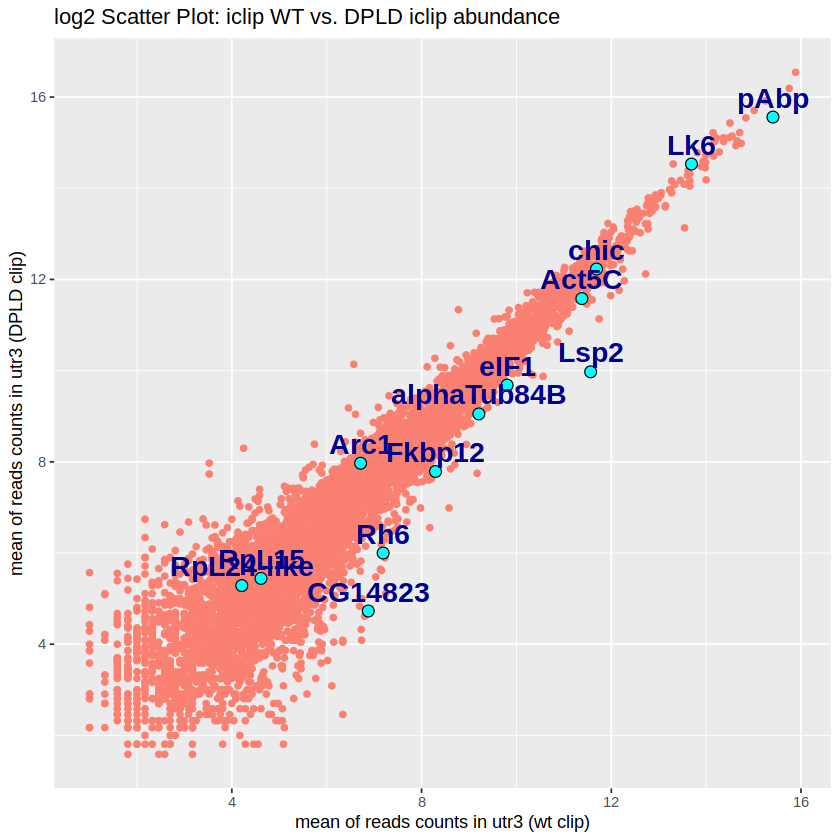

In [74]:
# Create a scatter plot
ggplot(clip_reads, aes(x = log2(iclip_UTR3_g080_mean_reads), y = log2(iclip_UTR3_dPLD_mean_reads))) +
  geom_point(color = "salmon") +
  geom_point(data = highlighted_data, aes(x = log2(iclip_UTR3_g080_mean_reads), y = log2(iclip_UTR3_dPLD_mean_reads)),
             size = 3, shape = 21, fill = "cyan", color = "black") +
  geom_text(data = highlighted_data, aes(x = log2(iclip_UTR3_g080_mean_reads), y = log2(iclip_UTR3_dPLD_mean_reads),
                                          label = highlighted_data$`Gene name`),
            vjust = -0.5, hjust = 0.5, size = 6, fontface='bold', color = "darkblue") +
  labs(x = " mean of reads counts in utr3 (wt clip) ", y = "mean of reads counts in utr3 (DPLD clip)", 
       title = "log2 Scatter Plot: iclip WT vs. DPLD iclip abundance")

# Normalization with DESeq2

In [60]:
head(clip_reads)

,replicate1_utr3,replicate2_utr3,iclip_UTR3_g080_mean_reads,dpld_replicate1_utr3,dpld_replicate2_utr3,iclip_UTR3_dPLD_mean_reads,Gene name
,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>
FBgn0000014,12,10,11,14,16,15.0,abd-A
FBgn0000015,4,14,9,12,34,23.0,Abd-B
FBgn0000017,512,574,543,668,785,726.5,Abl
FBgn0000024,3039,4317,3678,8387,8338,8362.5,Ace
FBgn0000028,83,61,72,210,145,177.5,acj6
FBgn0000032,9,47,28,28,14,21.0,Acph-1


In [84]:
df=clip_reads[,c('replicate1_utr3','replicate2_utr3',
           'dpld_replicate1_utr3','dpld_replicate2_utr3')]
rownames(df)=rownames(clip_reads)


In [85]:
#contructin DESeq2 object :
sample_info <- DataFrame(condition = c('WT','WT','DPLD','DPLD'), row.names = names(df))
sample_info$condition=as.factor(sample_info$condition)

dds <- DESeqDataSetFromMatrix(countData = as.matrix(df),colData = sample_info ,design = ~condition)

In [86]:
dds <- estimateSizeFactors(dds)
#estimate size factor
sizeFactors(dds)
#normalization
normalized_counts_byDeseq2 <- counts(dds, normalized=TRUE)
head(normalized_counts_byDeseq2)

# prepare files to save them later : by adding gene names
normalized_counts_byDeseq2=as.data.frame(normalized_counts_byDeseq2)
mapping_geneName =  getBM(attributes=c("ensembl_gene_id","external_gene_name"), mart=mart, values=normalized_counts_byDeseq2, uniqueRows=TRUE, bmHeader = T)
normalized_counts_byDeseq2$genes=row.names(normalized_counts_byDeseq2)
normalized_counts_byDeseq2 = merge(normalized_counts_byDeseq2, mapping_geneName, by.x='genes', by.y="Gene stable ID", all.x=TRUE, all.y=FALSE)

replicate1_utr3      replicate2_utr3 dpld_replicate1_utr3 
           0.6496407            0.9477230            1.3251462 
dpld_replicate2_utr3 
           1.2738071

,replicate1_utr3,replicate2_utr3,dpld_replicate1_utr3,dpld_replicate2_utr3
FBgn0000014,18.471748,10.55161,10.564872,12.56077
FBgn0000015,6.157249,14.77225,9.055605,26.69164
FBgn0000017,788.127924,605.66218,504.095335,616.26285
FBgn0000024,4677.970234,4555.12824,6329.113141,6545.73200
FBgn0000028,127.762925,64.36480,158.473084,113.83199
FBgn0000032,13.853811,49.59255,21.129745,10.99067


In [87]:
#calculating the means
normalized_counts_byDeseq2$wt_mean=rowMeans(normalized_counts_byDeseq2[,c('replicate1_utr3','replicate2_utr3')])
normalized_counts_byDeseq2$DPLD_mean=rowMeans(normalized_counts_byDeseq2[,c('dpld_replicate1_utr3','dpld_replicate2_utr3')])
head(normalized_counts_byDeseq2)

,genes,replicate1_utr3,replicate2_utr3,dpld_replicate1_utr3,dpld_replicate2_utr3,Gene name,wt_mean,DPLD_mean
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,FBgn0000014,18.471748,10.55161,10.564872,12.56077,abd-A,14.51168,11.56282
2,FBgn0000015,6.157249,14.77225,9.055605,26.69164,Abd-B,10.46475,17.87362
3,FBgn0000017,788.127924,605.66218,504.095335,616.26285,Abl,696.89505,560.17909
4,FBgn0000024,4677.970234,4555.12824,6329.113141,6545.73200,Ace,4616.54924,6437.42257
5,FBgn0000028,127.762925,64.36480,158.473084,113.83199,acj6,96.06386,136.15254
6,FBgn0000032,13.853811,49.59255,21.129745,10.99067,Acph-1,31.72318,16.06021


In [88]:
highlight_genes <- c("chic", "Lk6", 'Act5C', 'Arc1','RpL24-like', 'RpL15',
                    "pAbp", "Rh6", "CG14823", "Fkbp12", "Lsp2", "eIF1","alphaTub84B")

highlighted_data <- normalized_counts_byDeseq2[normalized_counts_byDeseq2$`Gene name` %in% highlight_genes, ]

## PLOT 2: DESeq2 normalized read count on UTR3 G080 (WT) vs DPLD

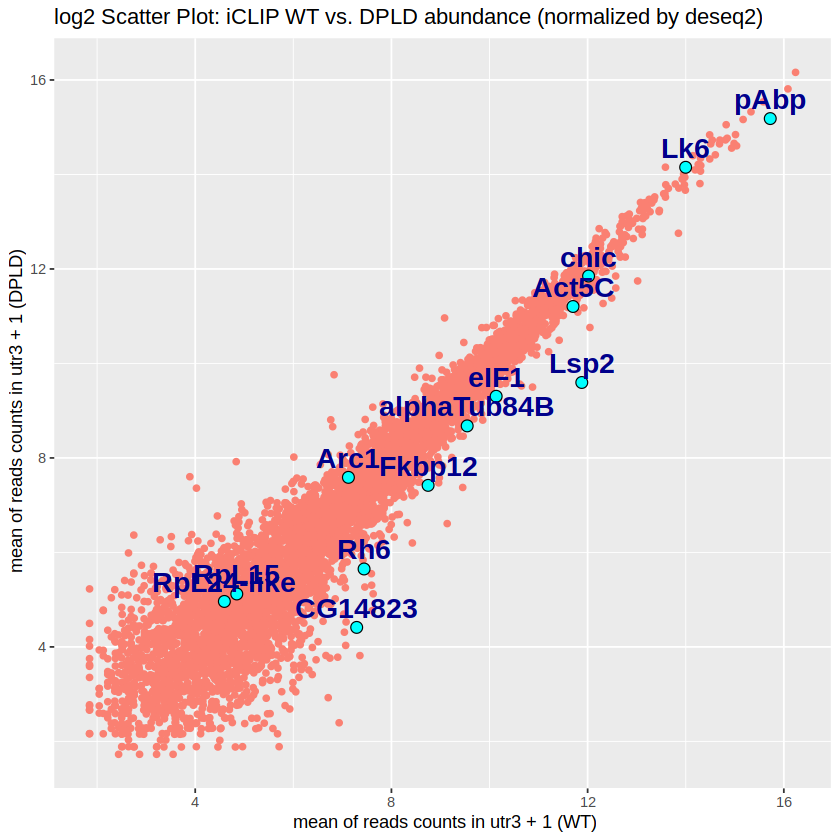

In [89]:
ggplot(normalized_counts_byDeseq2, aes(x = log2(wt_mean+1), y = log2(DPLD_mean+1))) +
  geom_point(color = "salmon") +
  geom_point(data = highlighted_data, aes(x = log2(wt_mean+1), y = log2(DPLD_mean+1)),
             size = 3, shape = 21, fill = "cyan", color = "black") +
  geom_text(data = highlighted_data, aes(x = log2(wt_mean+1), y = log2(DPLD_mean+1),
                                          label = `Gene name`),
            vjust = -0.5, hjust = 0.5, size = 6, fontface='bold', color = "darkblue") +
  labs(x = " mean of reads counts in utr3 + 1 (WT)", y = " mean of reads counts in utr3 + 1 (DPLD)", 
       title = "log2 Scatter Plot: iCLIP WT vs. DPLD abundance (normalized by deseq2)")


# crossing with peaks and cDNA

In [91]:
#the following table contains the list of genes that have at least 1 peaks which is supported by at least 5cDNA
#see : filter_peaks_cdna.ipynb
cdna_peaks_g080=read.csv2('/workspace/hlaghrissi/tmp_article/mergedG080_peaks_scores.csv', row.names='X')

In [92]:
data=merge(normalized_counts_byDeseq2,cdna_peaks_g080,by.x=c('genes','Gene name'),by.y=c('Var1','name'), all.x=TRUE, all.y=FALSE)
dim(data)
head(data)

[1] 5964   10

,genes,Gene name,replicate1_utr3,replicate2_utr3,dpld_replicate1_utr3,dpld_replicate2_utr3,wt_mean,DPLD_mean,Freq,score
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,FBgn0000014,abd-A,18.471748,10.55161,10.564872,12.56077,14.51168,11.56282,NA,NA
2,FBgn0000015,Abd-B,6.157249,14.77225,9.055605,26.69164,10.46475,17.87362,NA,NA
3,FBgn0000017,Abl,788.127924,605.66218,504.095335,616.26285,696.89505,560.17909,NA,NA
4,FBgn0000024,Ace,4677.970234,4555.12824,6329.113141,6545.73200,4616.54924,6437.42257,9,53
5,FBgn0000028,acj6,127.762925,64.36480,158.473084,113.83199,96.06386,136.15254,1,7
6,FBgn0000032,Acph-1,13.853811,49.59255,21.129745,10.99067,31.72318,16.06021,NA,NA


genes with NA values in Freq (number of significant peaks as defined by iCount) and score (cDNA) mean that they don't have at least 1 peak (supported by 5cDNA)